## Imports

In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import classification_report
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns

In [2]:
import sys
sys.path.append('../src')
from model.proba_model import get_past_meta, predict
from model.evaluation import get_classification_report

## Definitions

In [3]:
# ### Definitions
path_data_dir = '../data/'

list_assets = ["PETR3.SA","PRIO3.SA", "VALE3.SA", "GGBR3.SA", "ABCB4.SA", "ITUB3.SA", "FLRY3.SA", "RADL3.SA"]

relevant_cols = ['Date', 'Close', 'Volume']

In [4]:
list_prev_meta = [i for i in range(1,5)]

## Classification

### Dummy Model

#### Temporal train test split

In [5]:
n_prev_meta = 1


list_results = []
for asset in list_assets:
    
    print(f"""
#################
# asset: {asset}
#################          
          """)
    
    # get train contigency table 
    cont_tbl_train = pd.read_csv(path_data_dir + f"processed/train_contingency_table_price_history_{asset.replace('.', '_')}_meta_range({n_prev_meta})_dataset_ffill.csv", index_col=0, header=[i for i in range(n_prev_meta)])
    
    # create probability table
    df_probas = cont_tbl_train.apply(lambda x: [col/sum(x) for col in x])    
    
    # get test dataset
    test_dataset = pd.read_csv(path_data_dir + f"processed/test_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0)
    
    # get the past meta for all days    
    test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)

    # remove the first rows
    test_dataset = test_dataset.iloc[n_prev_meta:]
    
    # get y_test
    y_test = test_dataset.meta
    
    # predict based on probability table
    y_pred = test_dataset.past_meta.astype('int')
    
    # create df with results
    df_results_p = get_classification_report(y_test, y_pred)
    df_results_p['asset'] = asset
    
    print(classification_report(y_test, y_pred))
    
    
    list_results.append(df_results_p)
    
    df_results_p = df_results_p.drop(['weighted avg', 'macro avg', 'accuracy'])
    df_results_p.index = df_results_p.index.astype('int')
    df_results_p = df_results_p.reset_index()
    df_results_p.support = df_results_p.support.astype('int')
    
    df_results_p.drop(['asset'],axis = 1,inplace = True)
    df_results_p.rename(
        {
            'index':'p',
            "precision": 'precision',
            "recall": 'recall',
            "f1-score": 'f1-score',
            "support": "q"
        }
        
        
        ,axis = 1, inplace = True)

    df_results_p.sort_values('p', inplace = True)
    print(df_results_p.to_latex(index=False,float_format="%.2f"))
    
    
    
    
df_results = pd.concat(list_results)


#################
# asset: PETR3.SA
#################          
          
              precision    recall  f1-score   support

          -2       0.58      0.58      0.58        36
          -1       0.75      0.75      0.75       169
           0       0.84      0.84      0.84       458
           1       0.77      0.77      0.77       235
           2       0.63      0.63      0.63        62
           3       0.67      0.67      0.67         3

    accuracy                           0.79       963
   macro avg       0.71      0.71      0.71       963
weighted avg       0.79      0.79      0.79       963

\begin{tabular}{rrrrr}
\toprule
p & precision & recall & f1-score & q \\
\midrule
-2 & 0.58 & 0.58 & 0.58 & 36 \\
-1 & 0.75 & 0.75 & 0.75 & 169 \\
0 & 0.84 & 0.84 & 0.84 & 458 \\
1 & 0.77 & 0.77 & 0.77 & 235 \\
2 & 0.63 & 0.63 & 0.63 & 62 \\
3 & 0.67 & 0.67 & 0.67 & 3 \\
\bottomrule
\end{tabular}


#################
# asset: PRIO3.SA
#################          
          
      

#### Annual moving train test split

In [6]:
import pandas as pd
from datetime import timedelta, datetime,date
from tqdm import tqdm
from itertools import product
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt

import sys
sys.path.append('../src')
from data.data_split import split_data_by_year
from features.contigency_table import create_contigency_table
from model.proba_model import get_past_meta, predict
from model.evaluation import get_classification_report

In [7]:
df_results = pd.DataFrame({})

for asset in list_assets:    
    
    data = pd.read_csv(path_data_dir + f"processed/price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv")


    data['year'] = pd.to_datetime(data.Date).dt.year

    # create tuples (years train, years test)
    years = list(data.year.unique())
    train_test_years = [([years[i]], [years[i] + 1]) for i in range(len(years) - 1)]
    train_test_years
    
    for years_train, years_test in train_test_years:
    
        train_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_train)]
        test_dataset = data[pd.to_datetime(data.Date).dt.year.isin(years_test)]
                
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)

        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
        
        # get y_test
        y_test = test_dataset.meta
        
        # predict based on probability table
        y_pred = test_dataset.past_meta.astype('int')
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        df_results_p['years_train'] = str(years_train)
        df_results_p['years_test'] = str(years_test)
        
        df_results = pd.concat([df_results, df_results_p])

In [8]:
df_results.years_train = df_results.years_train.apply(lambda x: int(eval(x)[0]))
df_results.years_test = df_results.years_test.apply(lambda x: int(eval(x)[0]))

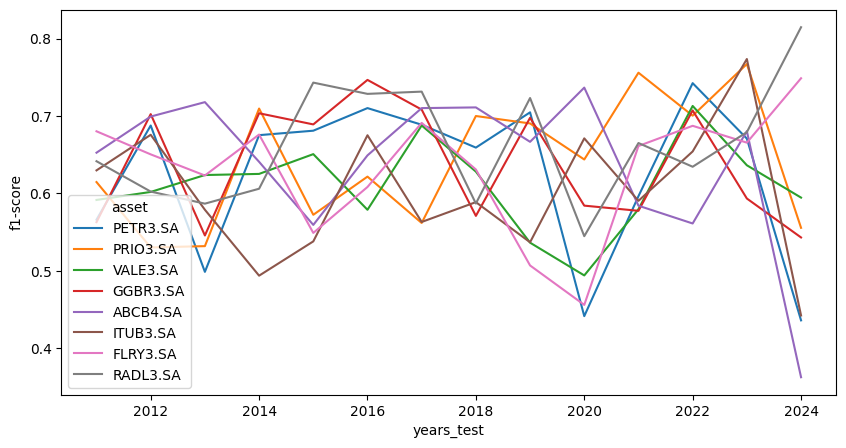

In [11]:
df_results_metric = df_results.loc['macro avg', :]


fig, ax = plt.subplots(figsize=(10, 5))


sns.lineplot(data=df_results_metric, x="years_test", y='f1-score', hue="asset", ax = ax)

plt.show()

### Bayesian dependent model

In [ ]:
df_results = pd.DataFrame({})

for n_prev_meta in tqdm(range(1, 3)):

    for asset in list_assets:
        
        # get train contigency table 
        cont_tbl_train = pd.read_csv(path_data_dir + f"processed/train_contingency_table_price_history_{asset.replace('.', '_')}_meta_range({n_prev_meta})_dataset_ffill.csv", index_col=0, header=[i for i in range(n_prev_meta)])
        
        # create probability table
        df_probas = cont_tbl_train.apply(lambda x: [col/sum(x) for col in x])    
        
        # get test dataset
        test_dataset = pd.read_csv(path_data_dir + f"processed/test_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0)
        
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)

        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
        
        # get y_test
        y_test = test_dataset.meta
        
        # predict based on probability table
        y_pred = test_dataset.past_meta.apply(lambda x: predict(x, df_probas))
        
        print('Number of nan: ',y_pred.isna().sum()/len(y_pred), '%')
        
        # when the value is nan, repeat the last predict
        y_pred.ffill(inplace=True)
        y_pred.fillna(0, inplace = True)
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        
        df_results = pd.concat([df_results, df_results_p])
                        
        
        if n_prev_meta == 1:
            
            # predict based on probability table
            y_pred = test_dataset.past_meta.astype('int')
            
            # when the value is nan, repeat the last predict
            y_pred.ffill(inplace=True)
            y_pred.fillna(0, inplace = True)
            
            # create df with results
            df_results_p = get_classification_report(y_test, y_pred)
            df_results_p['asset'] = asset
            df_results_p['n_prev_meta'] = 'DUMMY'
            
            df_results = pd.concat([df_results, df_results_p])

  0%|          | 0/2 [00:00<?, ?it/s]

Number of nan:  0.0 %
Number of nan:  0.0 %
Number of nan:  0.0 %
Number of nan:  0.0 %
Number of nan:  0.0 %
Number of nan:  0.0 %


 50%|█████     | 1/2 [00:00<00:00,  1.23it/s]

Number of nan:  0.0 %
Number of nan:  0.0 %
Number of nan:  0.002079002079002079 %
Number of nan:  0.0010395010395010396 %
Number of nan:  0.0 %
Number of nan:  0.0010395010395010396 %
Number of nan:  0.0 %
Number of nan:  0.0 %


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Number of nan:  0.0010395010395010396 %
Number of nan:  0.002079002079002079 %


In [ ]:
df_results

,precision,recall,f1-score,support,asset,n_prev_meta
0,0.842795,0.842795,0.842795,458.000000,PETR3.SA,1
accuracy,0.784008,0.784008,0.784008,0.784008,PETR3.SA,1
weighted avg,0.782091,0.784008,0.783027,963.000000,PETR3.SA,1
1,0.770213,0.770213,0.770213,235.000000,PETR3.SA,1
-1,0.751479,0.751479,0.751479,169.000000,PETR3.SA,1
...,...,...,...,...,...,...
-2,0.645833,0.645833,0.645833,48.000000,RADL3.SA,2
-1,0.630058,0.630058,0.630058,173.000000,RADL3.SA,2
macro avg,0.544323,0.517829,0.528071,962.000000,RADL3.SA,2
2,0.578947,0.392857,0.468085,28.000000,RADL3.SA,2


In [ ]:
test_dataset

,Date,Close,Volume,SMA_21,MSTD_21,Day_of_week,Weekend,Invalid_Days,diff_close_mean,diff_close_mean_z_score,meta,past_meta
3856,2021-07-13,25.413462,5880368.0,24.652014,0.810205,1,0,0,0.761447,0.939821,0,"(0, 0)"
3857,2021-07-14,25.480768,5002608.0,24.623168,0.766163,2,0,0,0.857600,1.119343,1,"(0, 0)"
3858,2021-07-15,25.673077,3605992.0,24.600274,0.724170,3,0,0,1.072802,1.481422,1,"(0, 1)"
3859,2021-07-16,26.048077,6034288.0,24.600274,0.724170,4,0,0,1.447802,1.999256,1,"(1, 1)"
3860,2021-07-17,26.048077,6034288.0,24.600274,0.724170,5,1,1,1.447802,1.999256,1,"(1, 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...
4813,2024-02-25,26.180000,5288600.0,25.508095,0.516242,6,1,1,0.671905,1.301530,1,"(1, 1)"
4814,2024-02-26,26.600000,7904200.0,25.537143,0.560019,0,0,0,1.062858,1.897895,1,"(1, 1)"
4815,2024-02-27,26.610001,10382700.0,25.566190,0.599646,1,0,0,1.043810,1.740712,1,"(1, 1)"
4816,2024-02-28,26.670000,3721900.0,25.590476,0.634228,2,0,0,1.079524,1.702107,1,"(1, 1)"


In [ ]:
cont_tbl_train

Meta -1 -3 -2             -1              0  ...    1       2              3  \
Meta -2 -1 -3  -2  -1  0  -2   -1   0  1 -2  ...    1   2   0   1    2  3 -1   
Meta                                         ...                               
-3       0  0   0   0  0   0    2   1  0  0  ...    0   0   0   0    0  0  0   
-2       3  2  85  27  5   5   24  17  0  0  ...    0   0   0   0    0  0  0   
-1       0  1  33  17  1  34  366  79  0  0  ...    1   0   0   0    0  0  0   
 0       0  0   1   2  0  13   86  35  1  3  ...  118  13   0   0    4  0  0   
 1       0  0   0   0  0   0    1   0  0  0  ...  532  67   3  37   47  2  0   
 2       0  0   0   0  0   0    0   0  0  0  ...   47   9  16  34  108  3  0   
 3       0  0   0   0  0   0    0   1  0  0  ...    2   0   0   0    2  0  1   

Meta -1           
Meta -2  1  2  3  
Meta              
-3       0  0  0  
-2       0  0  0  
-1       0  0  0  
 0       0  0  0  
 1       0  0  0  
 2       0  2  3  
 3       2  0  2  

[7 rows x 26 columns]

In [ ]:
df_probas

Meta -1   -3        -2                                      -1            \
Meta -2   -1        -3        -2        -1         0        -2        -1   
Meta                                                                       
-3       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.004175   
-2       1.0  0.666667  0.714286  0.586957  0.833333  0.096154  0.050104   
-1       0.0  0.333333  0.277311  0.369565  0.166667  0.653846  0.764092   
 0       0.0  0.000000  0.008403  0.043478  0.000000  0.250000  0.179541   
 1       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.002088   
 2       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 3       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

Meta -1                   0  ...         1                   2            \
Meta -2         0    1   -2  ...         1         2         0         1   
Meta                         ...                                           
-3       0.007519  0.0  0.0  ...  0.000000  0.000000  0.000000  0.000000   
-2       0.127820  0.0  0.0  ...  0.000000  0.000000  0.000000  0.000000   
-1       0.593985  0.0  0.0  ...  0.001429  0.000000  0.000000  0.000000   
 0       0.263158  1.0  1.0  ...  0.168571  0.146067  0.000000  0.000000   
 1       0.000000  0.0  0.0  ...  0.760000  0.752809  0.157895  0.521127   
 2       0.000000  0.0  0.0  ...  0.067143  0.101124  0.842105  0.478873   
 3       0.007519  0.0  0.0  ...  0.002857  0.000000  0.000000  0.000000   

Meta -1                   3                 
Meta -2         2    3   -1    1    2    3  
Meta                                        
-3       0.000000  0.0  0.0  0.0  0.0  0.0  
-2       0.000000  0.0  0.0  0.0  0.0  0.0  
-1       0.000000  0.0  0.0  0.0  0.0  0.0  
 0       0.024845  0.0  0.0  0.0  0.0  0.0  
 1       0.291925  0.4  0.0  0.0  0.0  0.0  
 2       0.670807  0.6  0.0  0.0  1.0  0.6  
 3       0.012422  0.0  1.0  1.0  0.0  0.4  

[7 rows x 26 columns]

In [ ]:
df_results= df_results.reset_index().rename({'index': 'class'}, axis = 1)
df_results

,class,precision,recall,f1-score,support,asset,n_prev_meta
0,0,0.842795,0.842795,0.842795,458.000000,PETR3.SA,1
1,accuracy,0.784008,0.784008,0.784008,0.784008,PETR3.SA,1
2,weighted avg,0.782091,0.784008,0.783027,963.000000,PETR3.SA,1
3,1,0.770213,0.770213,0.770213,235.000000,PETR3.SA,1
4,-1,0.751479,0.751479,0.751479,169.000000,PETR3.SA,1
...,...,...,...,...,...,...,...
217,-2,0.645833,0.645833,0.645833,48.000000,RADL3.SA,2
218,-1,0.630058,0.630058,0.630058,173.000000,RADL3.SA,2
219,macro avg,0.544323,0.517829,0.528071,962.000000,RADL3.SA,2
220,2,0.578947,0.392857,0.468085,28.000000,RADL3.SA,2


In [ ]:
df_f1_macro = df_results[
    (df_results['class'] == 'macro avg') &
    (df_results['n_prev_meta'] != 'DUMMY')
    ][['f1-score', 'asset' ,'n_prev_meta']]
df_f1_macro

,f1-score,asset,n_prev_meta
6,0.596290,PETR3.SA,1
22,0.741171,PRIO3.SA,1
42,0.633368,VALE3.SA,1
61,0.563061,GGBR3.SA,1
81,0.571177,ABCB4.SA,1
99,0.538494,ITUB3.SA,1
117,0.701460,FLRY3.SA,1
137,0.619564,RADL3.SA,1
153,0.492615,PETR3.SA,2
162,0.581094,PRIO3.SA,2


<Axes: xlabel='n_prev_meta', ylabel='f1-score'>

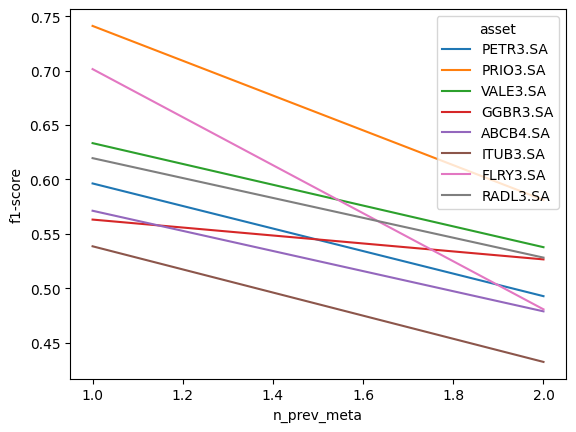

In [ ]:
sns.lineplot(data=df_f1_macro, x="n_prev_meta", y="f1-score", hue="asset")

In [ ]:
df_results[
    (df_results['class'] == 'macro avg') &
    (df_results['n_prev_meta'] == 'DUMMY')
    ][['f1-score', 'asset' ,'n_prev_meta']].sort_values('asset')

,f1-score,asset,n_prev_meta
90,0.569522,ABCB4.SA,DUMMY
126,0.701460,FLRY3.SA,DUMMY
71,0.658328,GGBR3.SA,DUMMY
109,0.536868,ITUB3.SA,DUMMY
14,0.707253,PETR3.SA,DUMMY
30,0.741171,PRIO3.SA,DUMMY
145,0.611354,RADL3.SA,DUMMY
50,0.703038,VALE3.SA,DUMMY


In [ ]:
df_results[
    (df_results['class'] == 'macro avg') &
    (df_results['n_prev_meta'] == 1)
    ][['f1-score', 'asset' ,'n_prev_meta']].sort_values('asset')

,f1-score,asset,n_prev_meta
81,0.571177,ABCB4.SA,1
117,0.701460,FLRY3.SA,1
61,0.563061,GGBR3.SA,1
99,0.538494,ITUB3.SA,1
6,0.596290,PETR3.SA,1
22,0.741171,PRIO3.SA,1
137,0.619564,RADL3.SA,1
42,0.633368,VALE3.SA,1
